<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4. Model Evaluation and Analysis</strong></h2>
  <p style="color:#333333;">Analysis and Comparison Deep Dives</p>
</div>

<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.1 Baseline Model TF-IDF + Logistic Regression</strong></h2>
  <p style="color:#333333;"></p>
</div>

In [1]:
#loading all Libraries here
import pandas as pd
import numpy as np
import joblib
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#we first load the saved testing data

test_df = pd.read_csv('test_dataset.csv')

test_df.head()

,text,target,text_length
0,looked razr first time today unregistered sim ...,0,68
1,MENTION thankseven thought cant figure put pic...,0,55
2,love leave goodnight twearth,4,28
3,highlander drop surge citycentre lakehills hig...,0,62
4,dont lab long tomorrow reaction going take sup...,0,82


In [3]:
# Next, we separate features and labels, dropping any rows where 'text' or 'target' is null

test_df = test_df.dropna(subset=["text", "target"])

X_test = test_df['text'].str.replace('MENTION', 'mentionuser', regex=False)  # Replace 'MENTION' with 'mentionuser' in the 'text' column
y_test = test_df['target']  


In [4]:
# We encode target to 0 and 1 to accommodate for what we did in training phase for the sigmoids

y_test = np.where(y_test == 4, 1.0, 0.0).astype(np.float32)

In [5]:
# Now we load the saved model for TF-IDF Logistic Regression
pipeline = joblib.load('tfidf_logreg_pipeline.joblib')

In [6]:
# we make predictions
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.68      0.73     80652
         1.0       0.80      0.87      0.83    119962

    accuracy                           0.79    200614
   macro avg       0.79      0.78      0.78    200614
weighted avg       0.79      0.79      0.79    200614

Accuracy Score: 0.7946304844128526
Confusion Matrix:
 [[ 55209  25443]
 [ 15757 104205]]


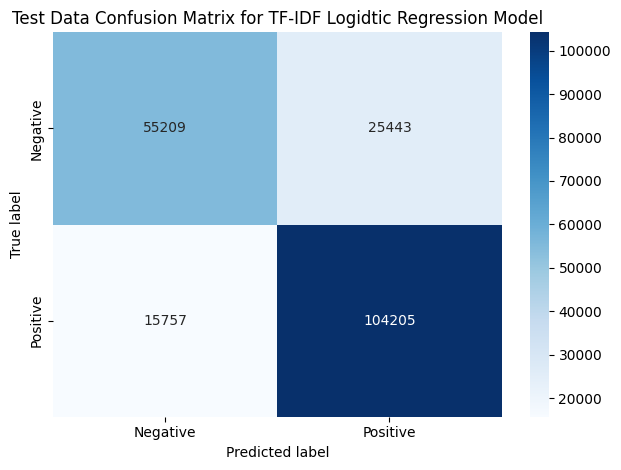

ROC-AUC Score: 0.8684091978156818


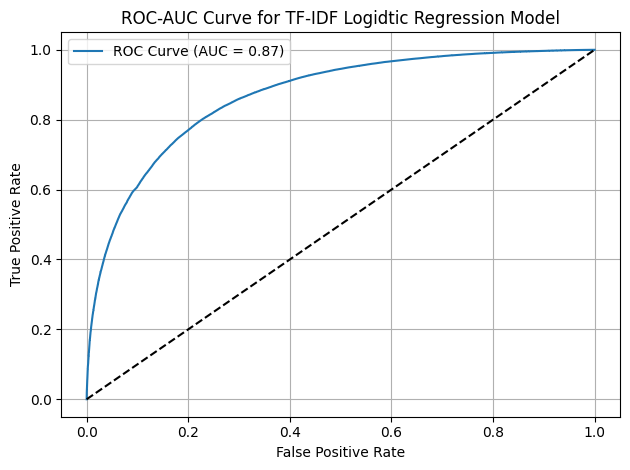

In [7]:
# Now we examine how well the model performed on the test data


# 1. Get predicted probabilities for the positive class (which we have encoded as 1
positive_class_index = list(pipeline.classes_).index(1)
y_scores = y_proba[:, positive_class_index]  # Probabilities for class 1

# 2. Classification report and accuracy
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

# 3. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix Heatmap
labels = ['Negative', 'Positive']
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Test Data Confusion Matrix for TF-IDF Logidtic Regression Model')
plt.tight_layout()
plt.show()

# 4. ROC-AUC
roc_auc = roc_auc_score(y_test, y_scores)
print("ROC-AUC Score:", roc_auc)

# 5. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC Curve for TF-IDF Logidtic Regression Model')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.2 LSTM Model</strong></h2>
  <p style="color:#333333;"></p>
</div>

In [1]:
# load all libraries here
import pandas as pd
import numpy as np
from gensim.utils import simple_preprocess
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

2025-07-19 07:59:27.211393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752926367.232840 2259143 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752926367.239423 2259143 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1752926367.257556 2259143 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752926367.257573 2259143 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1752926367.257575 2259143 computation_placer.cc:177] computation placer alr

In [2]:
# we load the test data here

test_df = pd.read_csv('test_dataset.csv')

test_df.head()

,text,target,text_length
0,looked razr first time today unregistered sim ...,0,68
1,MENTION thankseven thought cant figure put pic...,0,55
2,love leave goodnight twearth,4,28
3,highlander drop surge citycentre lakehills hig...,0,62
4,dont lab long tomorrow reaction going take sup...,0,82


In [3]:
# Next, we separate features and labels, dropping any rows where 'text' or 'target' is null

test_df = test_df.dropna(subset=["text", "target"])

X_test = test_df['text'].replace('MENTION', 'mentionuser', regex=False).astype(str)  # Replace 'MENTION' with 'mentionuser' in the 'text' column
y_test = test_df['target']  

In [4]:
# We encode target to 0 and 1 to accommodate for what we did in training phase for the sigmoids

y_test = np.where(y_test == 4, 1.0, 0.0).astype(np.float32)

In [5]:
# next, we rebuild our tokenizer as we have done in training phase

# Load and preprocess training data to re-fit tokenizer
train_df = pd.read_csv('train_dataset.csv')  
tokenized_train = train_df['text'].astype(str).apply(simple_preprocess).tolist()
tokenized_train_texts = [' '.join(tokens) for tokens in tokenized_train]

tokenizer = Tokenizer(num_words=82014)  # Use the same value as we did in training
tokenizer.fit_on_texts(tokenized_train_texts)

# Tokenize and preprocess test data
tokenized_test = X_test.apply(simple_preprocess).tolist()
tokenized_test_texts = [' '.join(tokens) for tokens in tokenized_test]

X_test_seq = tokenizer.texts_to_sequences(tokenized_test_texts)

# Compute max_len dynamically based on training
X_train_seq = tokenizer.texts_to_sequences(tokenized_train_texts)
max_len = max(len(seq) for seq in X_train_seq)

X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post')


In [6]:
# now, we load the LSTM trained model

model_LSTM = load_model('sentiment_lstm_model.keras')


I0000 00:00:1752926421.922320 2259143 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 11437 MB memory:  -> device: 0, name: Tesla P100-PCIE-12GB, pci bus id: 0000:82:00.0, compute capability: 6.0
/courses/IE7500.202550/shared/conda_env_1/lib/python3.12/site-packages/keras/src/trainers/trainer.py:212: UserWarning: Model doesn't support `jit_compile=True`. Proceeding with `jit_compile=False`.
  warnings.warn(


In [7]:
# Next, we make predictions 

y_pred_proba = model_LSTM.predict(X_test_pad)
y_pred = (y_pred_proba >= 0.5).astype(int).flatten()


I0000 00:00:1752926449.846355 2259235 cuda_dnn.cc:529] Loaded cuDNN version 90300


6270/6270 ━━━━━━━━━━━━━━━━━━━━ 36s 6ms/step


Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.58      0.64     80652
         1.0       0.75      0.84      0.79    119962

    accuracy                           0.74    200614
   macro avg       0.73      0.71      0.72    200614
weighted avg       0.73      0.74      0.73    200614

Accuracy Score: 0.7359855244399693
ROC-AUC Score: 0.7983568835879513
Confusion Matrix:
 [[ 47007  33645]
 [ 19320 100642]]


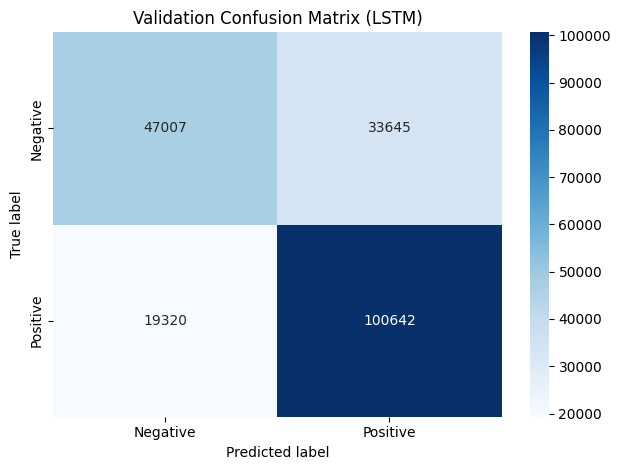

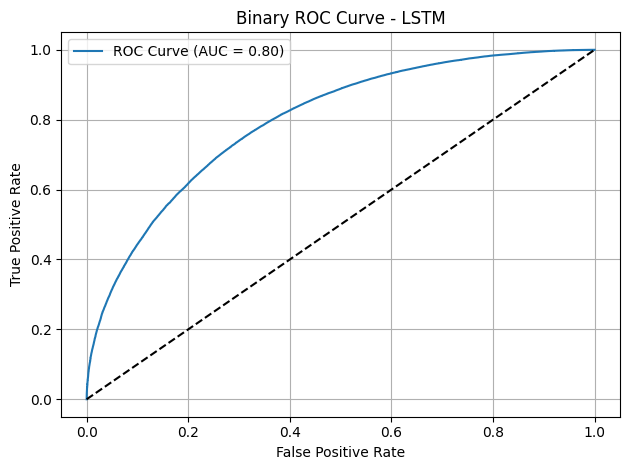

In [8]:
# Finally, we evaluate how well our LSTM Model performed

# 1. Evaluation Metrics
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=0))
print("Accuracy Score:", accuracy_score(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# 2. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# 3. Plot Confusion Matrix Heatmap
labels = ['Negative', 'Positive']
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Validation Confusion Matrix (LSTM)')
plt.tight_layout()
plt.show()

# 4. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - LSTM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>4.3 BERT Model</strong></h2>
  <p style="color:#333333;"></p>
</div>


In [16]:
# loading all libraries here

import pandas as pd
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import Dataset
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, roc_curve, confusion_matrix
from torch.utils.data import DataLoader

In [4]:
# we load the test data here

test_df = pd.read_csv('test_dataset.csv')

test_df.head()

,text,target,text_length
0,looked razr first time today unregistered sim ...,0,68
1,MENTION thankseven thought cant figure put pic...,0,55
2,love leave goodnight twearth,4,28
3,highlander drop surge citycentre lakehills hig...,0,62
4,dont lab long tomorrow reaction going take sup...,0,82


In [5]:
# Next, we separate features and labels, and similarly to what we did in training BERT, we fix the data type

test_df = pd.read_csv("test_dataset.csv")
test_df['target'] = test_df['target'].astype(int).replace({4: 1})  # convert positive 4 → 1
test_df['text'] = test_df['text'].astype(str)

X_test = test_df['text'].tolist()
y_test = test_df['target'].tolist()


In [6]:
# next, we convert to Hugging Face Dataset

test_dataset = Dataset.from_pandas(test_df[['text', 'target']])
test_dataset = test_dataset.rename_columns({'target': 'labels'})  # this is to match Trainer’s default label key

In [7]:
# next, we load the tokenizer and tokenize with same settings as we did in training

tokenizer = DistilBertTokenizerFast.from_pretrained("BERT_sentiment_model")

# Tokenize the test dataset
def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding="max_length", max_length=140)

test_tokenized = test_dataset.map(tokenize_function, batched=True)
test_tokenized.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])  

Map:   0%|          | 0/200614 [00:00<?, ? examples/s]

In [8]:
# we load our saved BERT model with the weights
model_BERT = DistilBertForSequenceClassification.from_pretrained("BERT_sentiment_model")
model_BERT.eval()  # Set model to evaluation mode

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [10]:
# then, we evaluate using Hugging Face Trainer
trainer_BERT = Trainer(model=model_BERT)
predictions_BERT = trainer_BERT.predict(test_tokenized)

In [11]:
# Next, we extract predictions and probabilities
y_pred_proba = torch.softmax(torch.tensor(predictions_BERT.predictions), dim=1)[:, 1].numpy()  # Probabilities for class 1
y_pred = np.argmax(predictions_BERT.predictions, axis=1) 
y_true = predictions_BERT.label_ids

Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.76     80652
           1       0.84      0.86      0.85    119962

    accuracy                           0.81    200614
   macro avg       0.81      0.80      0.81    200614
weighted avg       0.81      0.81      0.81    200614

Accuracy Score: 0.8139162770295194
ROC-AUC Score: 0.8901172770119125
Confusion Matrix:
 [[ 60705  19947]
 [ 17384 102578]]


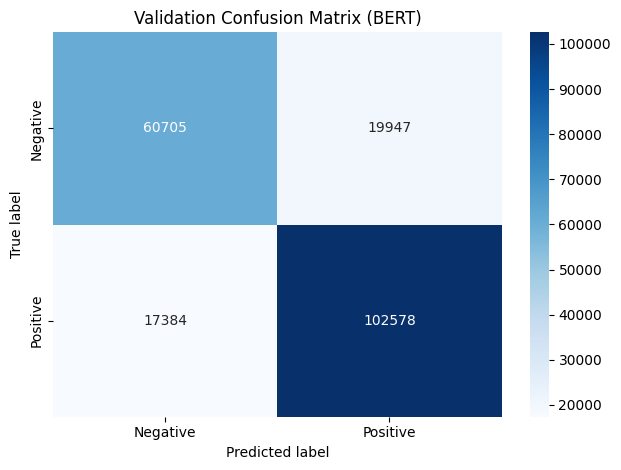

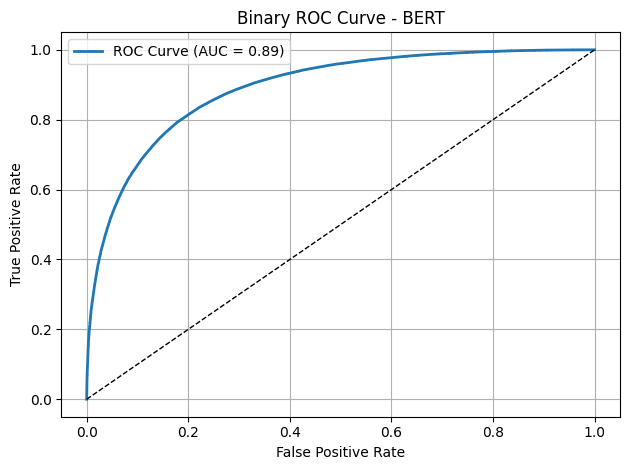

In [18]:
# Finally, we conduct evaluation of our model performance

# 1. Classification Metrics
print("Classification Report:\n", classification_report(y_true, y_pred, zero_division=0))
print("Accuracy Score:", accuracy_score(y_true, y_pred))

# 2. ROC-AUC Score
roc_auc = roc_auc_score(y_true, y_pred_proba)
print("ROC-AUC Score:", roc_auc)

# 3. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)

# Plot Confusion Matrix as Heatmap
plt.figure()
labels = ['Negative', 'Positive']
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Validation Confusion Matrix (BERT)')
plt.tight_layout()
plt.show()

# 4. Plot ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', linewidth=1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Binary ROC Curve - BERT')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>5 Discussion: Final Model Training </strong></h2>
  <p style="color:#333333;">Evaluate using accuracy, precision, recall, F1-score, confusion matrix, and ROC curve.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>6. Conclusion</strong></h2>
  <p style="color:#333333;">Summarize findings and insights, discuss trade-offs, and generalization potential.</p>
</div>



<div style="background-color:#e6f2ff; border-left:8px solid #0059b3; padding:20px; margin:20px 0;">
  <h2 style="color:#003366;"><strong>7. Future Work</strong></h2>
  <p style="color:#333333;">Suggested Improvements.</p>
</div>